EDA и FE целиком взяты из ДЗ к 3 занятию.

# init

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
parent_path = '/content/drive/MyDrive/Colab Notebooks/ml-buisness/lection3_materials/'

Mounted at /content/drive


In [2]:
!pip install shap

     |████████████████████████████████| 564 kB 5.4 MB/s 


In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve, f1_score, roc_auc_score
import matplotlib.pyplot as plt

import shap


# load data

In [4]:
# load data
data = pd.read_csv(parent_path + 'train_case2.csv', sep=';')
train = data.drop(columns='cardio').copy()
y_true = data['cardio']
data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


# common correctors

In [5]:
class Quantile_corrector(BaseEstimator, TransformerMixin):
  def __init__(self, field, lower=0.05, upper=0.95, method=np.median, calc_avg_on='fit'):
    self.lower = lower if 0 < lower < upper else 0
    self.upper = upper if lower < upper else 1
    self.field = field
    self.lower_quantile = None
    self.upper_quantile = None
    self.method = method
    self.avg = None
    self.calc_avg_on = calc_avg_on

  def fit(self, X, y=None):
    self.lower_quantile = X[self.field].quantile(self.lower)
    self.upper_quantile = X[self.field].quantile(self.upper)
    self.avg = self.method(X[self.field])
    return self
  
  def transform(self, X):
    X = X.copy()
    feat = X[self.field].copy()
    out_lower = feat < self.lower_quantile
    out_upper = feat > self.upper_quantile
    feat[out_lower | out_upper] = self.avg if self.calc_avg_on == 'fit' else self.method(feat)

    X[self.field] = feat
    corrected = out_lower | out_upper
    X[f'{self.field}_corrected'] = 0
    X.loc[corrected, f'{self.field}_corrected'] = 1
    return X

# EDA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Пропусков нет, это хорошо. 

In [7]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Features description
1. Age | Objective Feature | age | int (days)
2. Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |
3. Height | Objective Feature | height | int (cm) |
4. Weight | Objective Feature | weight | float (kg) |
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol |
    1: normal, 
    2: above normal, 
    3: well above normal |
8. Glucose | Examination Feature | gluc |
    1: normal, 
    2: above normal,
    3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Отчетливо видны выбросы в `height`,  `weight`, `ap_hi`, `ap_lo`

### target

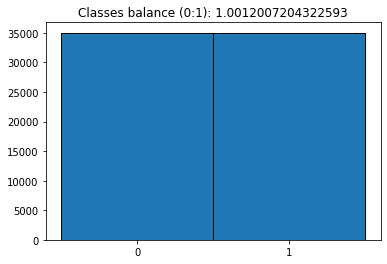

In [8]:
# распределение классов
target = 'cardio'

clases_count = data[target].value_counts()
disbalance = clases_count[0] / clases_count[1]

plt.hist(data[target], bins=2, edgecolor='black')
plt.title(f'Classes balance (0:1): {disbalance}')
plt.xticks([0.25, 0.75], labels=clases_count.index)
plt.show()

Дисбаланс классов незначительный

### age

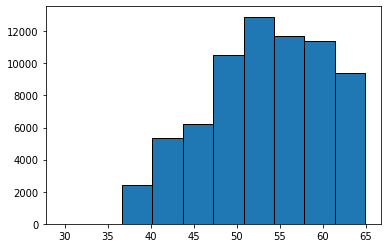

In [9]:
plt.hist(data['age'] / 365.25, edgecolor='black')
plt.show()

Выбросов и неадекватных значений по графику не видно

### gender

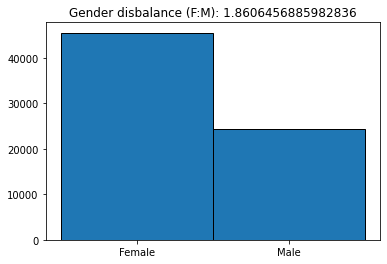

In [10]:
cls_count = data['gender'].value_counts()
disbal = cls_count[1] / cls_count[2]
plt.hist(data['gender'], bins=2, edgecolor='black')
plt.title(f'Gender disbalance (F:M): {disbal}')
plt.xticks([1.25, 1.75], labels=['Female', 'Male'])
plt.show()

Женщин в выборке почти в 2 раза больше, чем мужчин

### height

Самый низкорослый человек в мире имел рост ~67см, соотв. все, что ниже этого значения абсолютно точно - некорректно. Попробуем ограничить выборку по квантилям.

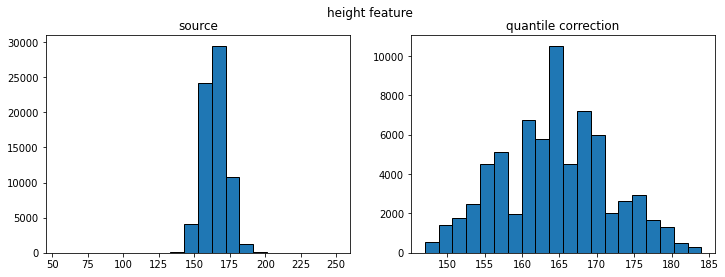

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('height feature')
ax[0].set_title('source')
ax[0].hist(data['height'], edgecolor='black', bins=20)
ax[1].set_title('quantile correction')
qc = Quantile_corrector('height', lower=0.01, upper=0.99, method=np.median, calc_avg_on='fit')
qc.fit(data)
ax[1].hist(qc.transform(data)['height'], edgecolor='black', bins=20)
plt.show()

### weight

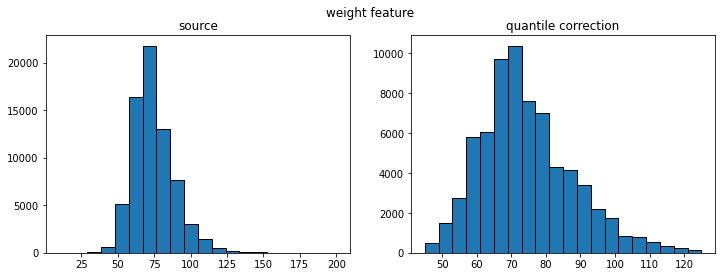

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('weight feature')
ax[0].set_title('source')
ax[0].hist(data['weight'], edgecolor='black', bins=20)
ax[1].set_title('quantile correction')
qc = Quantile_corrector('weight', lower=0.005, upper=0.995, method=np.median, calc_avg_on='fit')
qc.fit(data)
ax[1].hist(qc.transform(data)['weight'], edgecolor='black', bins=20)
plt.show()

Распределение веса, в целом, выглядит вполне возможным, но есть небольшое кол-во экстремально малых значений, которые выглядят неправдоподобно.
При этом высокие значения вполне реальны и могут быть обоснованны в контексте задачи

### ap_hi

Давление не может быть открицательным. Норма систолического давления лежит в диапазоне от 90 до 120. 

Снижение давления на 20% (и более) от обычного значения это уже гипотензия и требует неотложной медицинской помощи. В абсолютных цифрах это значение ~70, его и примем за минимально допустимое.

Систоличесское давление 250 это совсем уже гипертонический криз, поэтому примем это значение за максимально допустимое.

In [13]:
data[data['ap_hi'] < 0].size

91

In [14]:
data[data['ap_hi'] < 70].head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
567,815,21281,1,168,78.0,14,90,2,1,0,0,1,1
927,1294,21867,2,175,70.0,14,90,3,1,0,0,1,1
979,1360,18225,1,172,65.0,11,80,1,3,0,0,1,0


In [15]:
data[data['ap_hi'] > 250].head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1876,2654,15116,1,160,60.0,902,60,1,1,0,0,1,0
2014,2845,22712,2,167,59.0,906,0,1,1,0,0,1,0
4817,6822,14425,1,168,63.0,909,60,2,1,0,0,1,0


In [16]:
class Correct_ap_hi(BaseEstimator, TransformerMixin):
  def __init__(self, method=np.median, calc_avg_on='fit'):
    self.avg = None
    self.method = method
    self.calc_avg_on = calc_avg_on

  def fit(self, X, y=None):
    self.avg = self.method(X['ap_hi'])
    return self
  
  def transform(self, X):
    # select column
    feat = X['ap_hi'].copy()
    # switch sign for negative values
    out_neg = feat < 0
    feat[out_neg] = -feat[out_neg]
    # correct extremely low values
    out_lower = feat < 70
    feat[out_lower] = feat[out_lower] * 10
    # correct extremely high values
    out_upper = feat > 250
    feat[out_upper] = (feat[out_upper] / 10 ** np.round(np.log10(feat[out_upper]) - 2)).astype(np.int64)
    # correct secondary outliers
    out_secondary = (feat < 70) | (feat > 250)
    # feat[out_secondary] = int(feat.mean())
    feat[out_secondary] = int(self.avg if self.calc_avg_on == 'fit' else self.method(feat[~out_secondary]))

    X = X.copy()
    X['ap_hi'] = feat
    corrected = out_neg | out_lower | out_upper | out_secondary
    X['ap_hi_corrected'] = 0
    X.loc[corrected == True, 'ap_hi_corrected'] = 1
    return X

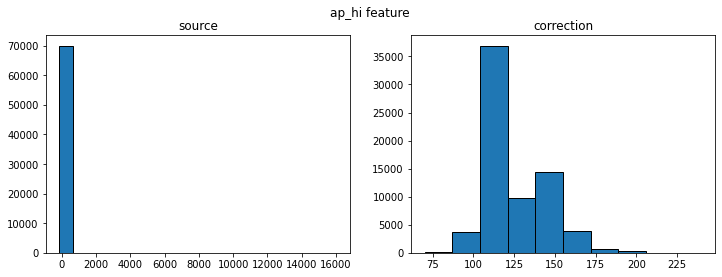

In [17]:
# ap_hi
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('ap_hi feature')
ax[0].set_title('source')
ax[0].hist(data['ap_hi'], edgecolor='black', bins=20)
ax[1].set_title('correction')
qc = Correct_ap_hi(method=np.median, calc_avg_on='fit')
qc.fit(data)
ax[1].hist(qc.transform(data)['ap_hi'], edgecolor='black')
plt.show()

### ap_lo

Давление не может быть открицательным. Норма диастолического давления лежит в диапазоне от 60 до 80. 

Как базовое решение, исправим пропуски мат.ожиданием/медианой.

In [18]:
data[data['ap_lo'] < 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,85816,22571,1,167,74.0,15,-70,1,1,0,0,1,1


In [19]:
data.loc[(data['ap_lo'] >= 0) & (data['ap_lo'] < 48), 'ap_lo'].size

77

In [20]:
data.loc[data['ap_lo'] > 160, 'ap_lo'].size

966

In [21]:
class Correct_ap_lo(BaseEstimator, TransformerMixin):
  def __init__(self, method=np.median, calc_avg_on='fit'):
    self.avg = None
    self.method = method
    self.calc_avg_on = calc_avg_on

  def fit(self, X, y=None):
    self.avg = self.method(X['ap_lo'])
    return self
  
  def transform(self, X):
    # select column
    feat = X['ap_lo'].copy()
    # switch sign for negative values
    out_neg = feat < 0
    feat[out_neg] = -feat[out_neg]
    # correct extremely low values with meanc
    out_lower_baseline = (feat >= 0) & (feat <= 48)
    # correct extremely high values with meanc
    out_upper_baseline = feat > 160
    feat[out_lower_baseline | out_upper_baseline] = int(self.avg if self.calc_avg_on == 'fit' else feat[~out_lower_baseline & ~out_upper_baseline].median())

    X = X.copy()
    X['ap_lo'] = feat
    corrected = out_lower_baseline | out_upper_baseline
    X['ap_lo_corrected'] = 0
    X.loc[corrected,  'ap_lo_corrected'] = 1
    return X

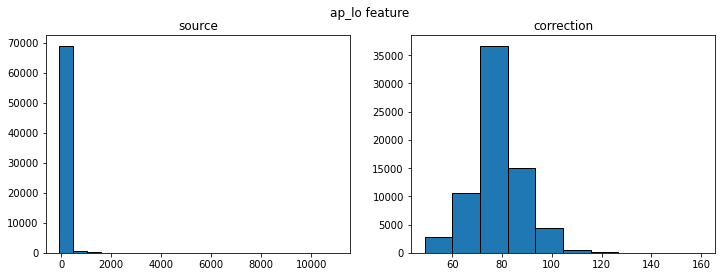

In [22]:
# ap_lo
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('ap_lo feature')
ax[0].set_title('source')
ax[0].hist(data['ap_lo'], edgecolor='black', bins=20)
ax[1].set_title('correction')
qc = Correct_ap_lo(method=np.median, calc_avg_on='fit')
qc.fit(data)
ax[1].hist(qc.transform(data)['ap_lo'], edgecolor='black')
plt.show()

# featuring

In [23]:
class Featuring(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    X = X.copy()
    # classic BMI
    X['BMI'] = X['weight'] / (X['height'] / 100) ** 2
    # new BMI (by Nick Trefethen)
    X['new_BMI'] = 1.3 * X['weight'] / (X['height'] / 100) ** 2.5
    
    return X

In [24]:
class DropColumns(BaseEstimator, TransformerMixin):
  def __init__(self, drop=[], leave=[]):
    self.drop = drop
    self.leave = leave

  def fit(self, X, y=None):
    self.leave = list(set(self.leave) & set(X.columns))
    self.drop = list(set(self.drop) & set(X.columns))
    return self

  def transform(self, X):
    if self.leave:
      return X[self.leave]
    elif self.drop:
      return X.drop(columns=self.drop)
    else:
      return X

In [25]:
class DataScaler(BaseEstimator, TransformerMixin):
  def __init__(self, scaler, scale=[], keep=[], keepsuffix=[]):
    self.scaler = scaler()
    self.scale = scale
    self.keep = keep
    self.keepsuffix = keepsuffix
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    df = X.copy()
    if self.keep:
      columns = [col for col in df.columns if col not in self.keep]
    elif not self.scale:
      columns = df.columns
    else:      
      columns = [col for col in self.scale if col in df.columns]
    
    columns = [col for col in columns if not any([col.startswith(suff) for suff in self.keepsuffix])]

    self.scaler.fit(df[columns])
    df[columns] = self.scaler.transform(df[columns])
    return df

# pipeline

In [26]:
prepare = Pipeline([('height_correction', Quantile_corrector('height', lower=0.01, upper=0.99)),
                    ('weight_correction', Quantile_corrector('weight', lower=0.0025, upper=1)),
                    ('ap_hi correction', Correct_ap_hi(method=np.median, calc_avg_on='fit')),
                    ('ap_lo correction', Correct_ap_lo(method=np.median, calc_avg_on='fit')),
                    ('featuring', Featuring()),
                    ('drop', DropColumns(drop=['id'])),
                    ])

# modeling

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y_true, test_size=0.3, random_state=13)
prepare.fit(X_train, y_train)
X_train = prepare.transform(X_train)
X_valid = prepare.transform(X_valid)

model =  LGBMClassifier(n_jobs=-1, max_depth=8, random_state=17)
model.fit(X_train, y_train)

pred_proba = model.predict_proba(X_valid)[:, 1]
pred = model.predict(X_valid)

F1: 0.7214
roc-auc: 0.7999


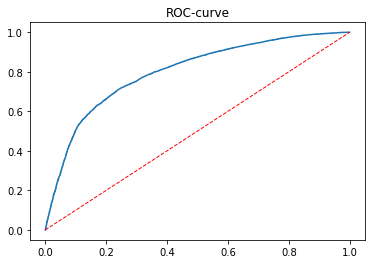

In [28]:
FPR, TPR, thr = roc_curve(y_valid, pred_proba)

plt.title('ROC-curve')
plt.plot(FPR, TPR);
plt.plot([0, 1], [0, 1], '--', lw=1, color='red');
print(f'F1: {f1_score(y_valid, pred):.4f}\n' \
      f'roc-auc: {roc_auc_score(y_valid, pred_proba):.4f}')

# shap

In [29]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### summary plot

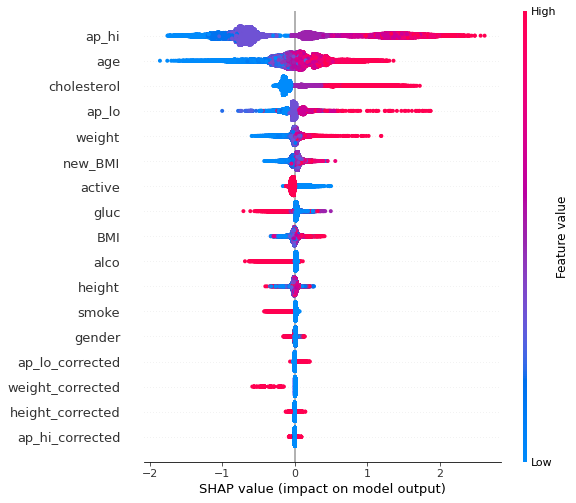

In [58]:
# summary plot по всем данным для 1-го класса
shap.summary_plot(shap_values[1], X_train, )

топ-5 самых значимых признаков:
1. систолическое давление
2. возраст
3. показатель холестерина
4. диастолическое давление
5. вес

Для данных признаков наблюдается прямая зависимость: : чем выше признак, тем больше вероятность заболевания

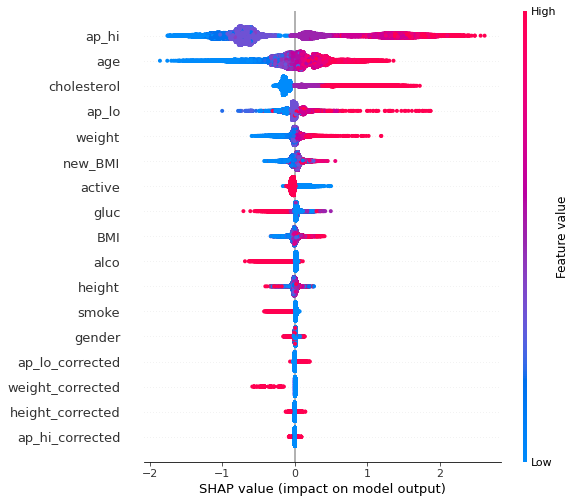

In [66]:
# summary plot по 10% данных для 1-го класса
frac = 0.1 + 0.9
_slc = int(X_train.shape[0] * frac)     # slice
shap.summary_plot(shap_values[1][:_slc], X_train[:_slc])

Идентичная картина

### force plot

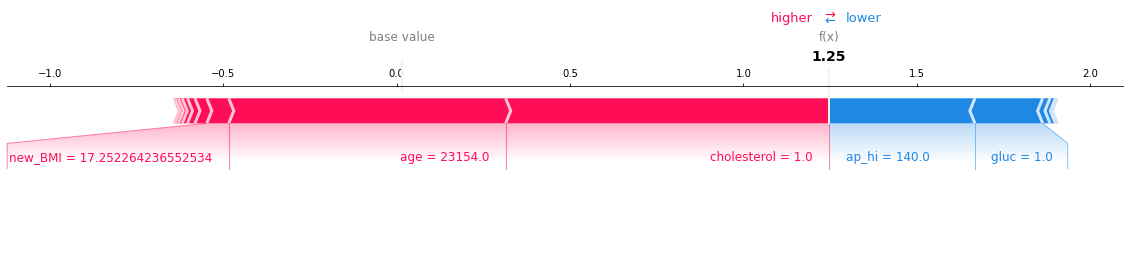

In [30]:
# вклад признаков в предсказание вероятности указанного класса `cl` для объекта `obj`
# shap.initjs()
cl = 1
obj = 10222
shap.force_plot(explainer.expected_value[cl], shap_values[cl][0, :], X_train.iloc[obj, :], matplotlib=True)

В предсказание вероятности объекта с индексом `10222` быть 1-ым классом (= иметь сердечно-сосудистое заболевание) основной вклад вносят следующие признаки:
1. Систолическое давление: увеличивает вероятность
2. показатель глюгозы: увеличивает вероятность
3. показатель холестерина: снижает вероятность
4. возраст: снижает вероятность
5. BMI (Nick Trefethen's formula): снижает вероятность

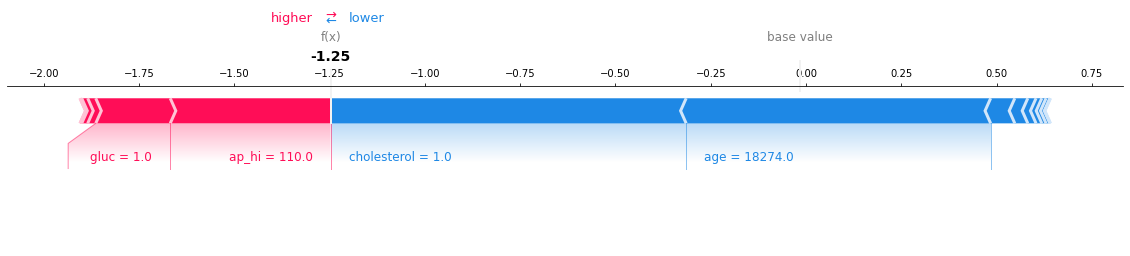

In [31]:
# shap.initjs()
cl = 0
obj = 9689
shap.force_plot(explainer.expected_value[cl], shap_values[cl][0, :], X_train.iloc[obj, :], matplotlib=True)

В предсказание вероятности объекта с индексом `9689` быть 0-ым классом (= не иметь сердечно-сосудистое заболевание) основной вклад вносят следующие признаки:
1. Систолическое давление: снижает вероятность
2. показатель глюгозы: снижает вероятность
3. показатель холестерина: увеличивает вероятность
4. возраст: увеличивает вероятность

При интерпретации классификатора надо внимательно следить за тем, вероятность какого класса анализируется.